## Description:

    Ordination using PCoA of top 200 OTUs

* Trends between genotypes are not as evident when dataset is pruned to top 200 OTUs
* This hold true whether data set is pruned before or after transforming counts to relative abundance.  

# Init

In [38]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)
library(phyloseq)
library(lme4)
library(lmerTest)
library(MuMIn)

In [40]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


# Loading phyloseq object

In [41]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [42]:
%%R 
# loading

physeq.thresh = readRDS('ERA_thresh.rds')
physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = subset_samples(physeq, TimePoint != "T0")

TopNOTUs = names(sort(taxa_sums(physeq), TRUE)[1:200])


# #Uncomment below to prune taxa before transforming to relative abundance
# physeq.thresh = prune_taxa(TopNOTUs, physeq.thresh)
# physeq = transform_sample_counts(physeq.thresh, function(x) x/sum(x))

#pruning already transformed object, so relative abundances will not change, just the number of OTUs in analysis
physeq = prune_taxa(TopNOTUs, physeq)

physeq = transform_sample_counts(physeq, function(OTU) sqrt(OTU))
physeq = subset_samples(physeq, SeedTreatment == "Treated"| Genotype == "Bare") # see seed treatment notebook for comparison
sample_data(physeq)$Planted = ifelse(sample_data(physeq)$Genotype == "Bare", "Bare", "Rhizosphere")
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 220 samples ]
sample_data() Sample Data:       [ 220 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [43]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)

## Calculate pairwise weighted Unifrac distances between samples

In [44]:
%%R
registerDoParallel(cores=28)
wunif.dist = phyloseq::distance(physeq, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [45]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(physeq, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [46]:
%%R
physeq %>% 
    sample_data() %>%
    .$Plant %>%
    levels()

 [1] "322"     "330"     "339"     "3394"    "3475"    "34M95"   "34N42"  
 [8] "3517"    "354"     "3541"    "3618"    "Bare"    "P1151HR"


## PCoA with Bray-Curtis 

In [47]:
%%R
pcoa = ordinate(physeq, 
                method = "PCoA", 
                distance =bray.dist)

p.df = plot_ordination(physeq, pcoa, justDF = TRUE)


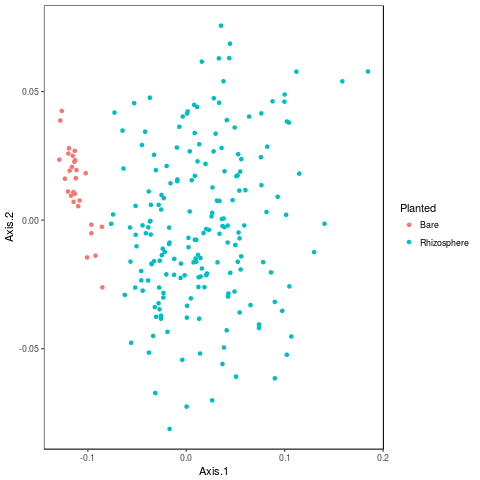

In [48]:
%%R

p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=Planted)) +
    theme_pub()
        
p

In [49]:
%%R
ordMean = p.df %>% 
    group_by(Genotype, R_Year, Fert, TimePoint) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1)),
             mAxis.2 = mean(Axis.2), 
             seAxis.2 = sd(Axis.2)/sqrt(length(Axis.2)))




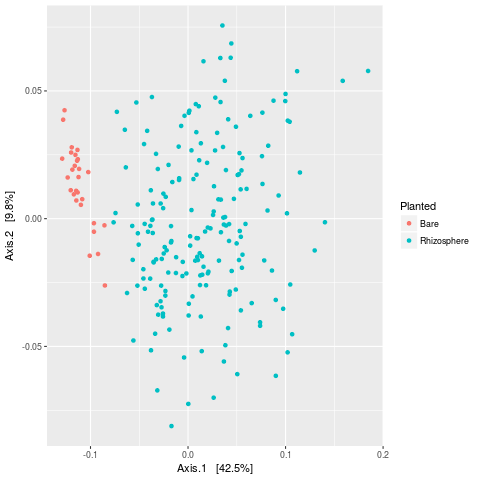

In [50]:
%%R
plot_ordination(physeq, pcoa, color = "Planted")

# PCoA of global data faceted by sampling date

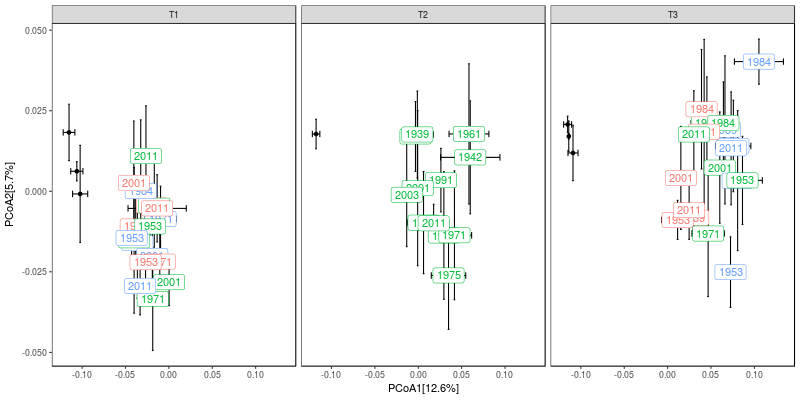

In [51]:
%%R -w 800 -h 400
pF = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = Fert), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("PCoA1[12.6%]")+
    ylab("PCoA2[5.7%]")+
   facet_wrap(~TimePoint)

pF

### Closer look at T2

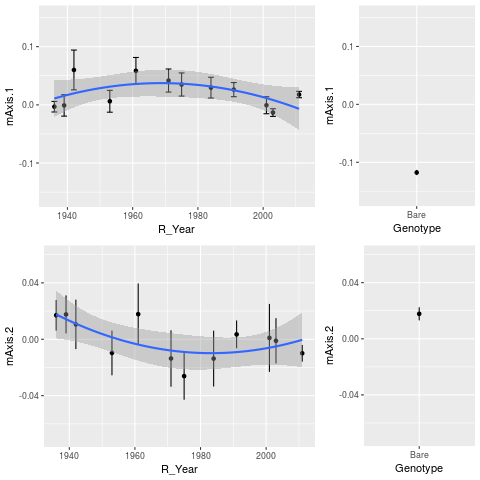

In [52]:
%%R
p1 = ggplot(subset(ordMean, TimePoint == "T2"), aes(x = R_Year, y = mAxis.1)) +
    geom_point() +
    ylim(c(-0.16, 0.155))+
     geom_errorbar(aes(ymin = mAxis.1 - seAxis.1, ymax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

p2 =    ggplot(subset(ordMean, TimePoint == "T2"), aes(x = R_Year, y = mAxis.2)) +
    geom_point() +
     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002)+
    ylim(c(-0.07, 0.06))+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))


    stat_smooth(method = "lm", formula = y ~ poly(x,2))
p3 =    ggplot(subset(ordMean, TimePoint == "T2" & Genotype == "Bare"), aes(x = Genotype, y = mAxis.1)) +
    geom_point() +
    ylim(c(-0.16, 0.155))+
     geom_errorbar(aes(ymin = mAxis.1- seAxis.1, ymax = mAxis.1 + seAxis.1),      
                color = "black",
                width = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

p4 =    ggplot(subset(ordMean, TimePoint == "T2" & Genotype == "Bare"), aes(x = Genotype, y = mAxis.2)) +
    geom_point() +
    ylim(c(-0.07, 0.06))+
     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

grid.arrange(p1, p3, p2,p4,  ncol = 2, widths = c(2,1))

### PCOA~RYear

* Axis 1

In [53]:
%%R
# on raw data
tmp = p.df %>% filter(TimePoint == "T2" & Genotype != "Bare")
m = lmer(Axis.1~poly(R_Year,2) + (1|Rep) + (1|Genotype), data = tmp)
anova(m) %>% print
summary(m)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                   Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
poly(R_Year, 2) 0.0045844 0.0022922     2     9  2.1171 0.1764
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Axis.1 ~ poly(R_Year, 2) + (1 | Rep) + (1 | Genotype)
   Data: tmp

REML criterion at convergence: -166.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7156 -0.5585 -0.1492  0.4648  3.2125 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Genotype (Intercept) 0.0002271 0.01507 
 Rep      (Intercept) 0.0002530 0.01591 
 Residual             0.0010827 0.03290 
Number of obs: 48, groups:  Genotype, 12; Rep, 4

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)       0.02137    0.01023  4.12200   2.088   0.1030  
poly(R_Year, 2)1 -0.02977    0.04462  9.00000  -0.667   0.5214  
poly(R_Year,

In [54]:
%%R
r.squaredGLMM(m)

      R2m       R2c 
0.1029562 0.3785046 


* Axis 2 

In [55]:
%%R
# on raw data
tmp = p.df %>% filter(TimePoint == "T2" & Genotype != "Bare")
m = lmer(Axis.2~poly(R_Year,2) + (1|Rep) + (1|Genotype), data = tmp)
anova(m) %>% print
summary(m)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                   Sum Sq   Mean Sq NumDF  DenDF F.value  Pr(>F)  
poly(R_Year, 2) 0.0041378 0.0020689     2 42.001  2.7043 0.07857 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Axis.2 ~ poly(R_Year, 2) + (1 | Rep) + (1 | Genotype)
   Data: tmp

REML criterion at convergence: -186

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.93046 -0.55330  0.03428  0.62180  2.41747 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Genotype (Intercept) 0.0000000 0.00000 
 Rep      (Intercept) 0.0003081 0.01755 
 Residual             0.0007651 0.02766 
Number of obs: 48, groups:  Genotype, 12; Rep, 4

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)      -0.0005803  0.0096417  3.0000000  -0.0

In [56]:
%%R
r.squaredGLMM(m)

       R2m        R2c 
0.07581811 0.34114698 


# Core adonis in time

In [57]:
%%R
physeq.core = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint != "T0" & Fert == "85")
physeq.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [58]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
core.wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

core.bray.dist = distance(physeq.core, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [59]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = core.bray.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep*TimePoint + Genotype*TimePoint, df, permutations = 999)
Coreadonis %>% print

print("")
print("weighted UniFrac")
d = core.wunif.dist
Coreadonis = adonis(formula = d ~ Rep*TimePoint + Genotype*TimePoint, df, permutations = 999)
Coreadonis

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep * TimePoint + Genotype * TimePoint,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep                 3   0.04813 0.016045  2.7619 0.08750  0.001 ***
TimePoint           2   0.10754 0.053768  9.2556 0.19548  0.001 ***
Genotype            5   0.03905 0.007810  1.3443 0.07098  0.079 .  
Rep:TimePoint       6   0.04172 0.006954  1.1970 0.07584  0.154    
TimePoint:Genotype 10   0.05227 0.005227  0.8998 0.09501  0.731    
Residuals          45   0.26142 0.005809         0.47519           
Total              71   0.55013                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] ""
[1] "weighted UniFrac"

Call:
adonis(formula = d ~ Rep * TimePoint + Genotype * TimePoint,      data = df, permutations = 999) 

Permutation: free
Number of permutations

## At each timepoint

### T1

In [60]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T1" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [61]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
Rep        3  0.023920 0.0079732 1.40565 0.17602  0.052 .
Genotype   5  0.026888 0.0053777 0.94806 0.19787  0.597  
Residuals 15  0.085084 0.0056723         0.62612         
Total     23  0.135892                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### T2

In [62]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T2" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [63]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.039091 0.0130303  2.3922 0.25759  0.001 ***
Genotype   5  0.030962 0.0061925  1.1369 0.20403  0.237    
Residuals 15  0.081704 0.0054469         0.53839           
Total     23  0.151757                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### T3

In [64]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T3" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [65]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
Rep        3  0.026847 0.0089489  1.4186 0.17327  0.046 *
Genotype   5  0.033467 0.0066934  1.0610 0.21600  0.346  
Residuals 15  0.094627 0.0063085         0.61073         
Total     23  0.154941                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# --Sandbox--

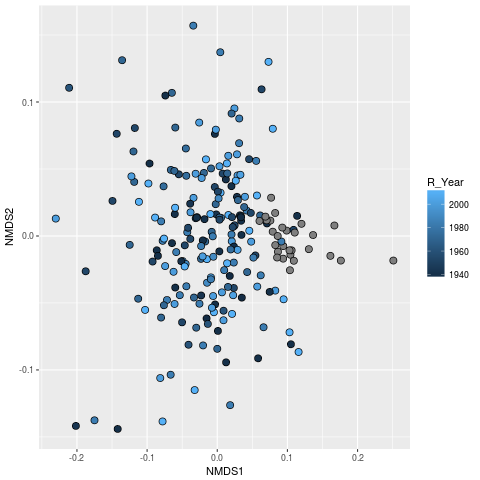

In [17]:
%%R
## generating plots
p1 = ggplot(p.F, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=R_Year), pch = 21, size = 3)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

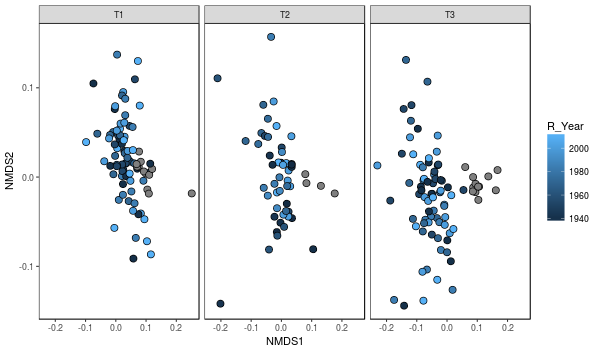

In [18]:
%%R -w 600 -h 350
p2 = p1 + facet_wrap(~TimePoint)+
theme_pub()
p2

In [19]:
# Create faceted figure with full dataset

# Adonis sampling date by rhizosphere effect

In [20]:
%%R
phy.core = subset_samples(physeq, Genotype %in% c("Bare","330", "354", "3517", "3475", "34M95", "P1151HR") &
                         Fert == "85"  & TimePoint != "T0")

In [21]:
%%R
sample_data(phy.core)$Planted

 [1] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [6] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
[11] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"       
[16] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
[21] "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere" "Bare"       
[26] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[31] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[36] "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[41] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[46] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere"
[51] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[56] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[61] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere"
[66] "Rhizosphere" "Rhizo

In [22]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.core, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [23]:
%%R
set.seed(101)

df = as(sample_data(phy.core), "data.frame")
d = bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Planted + Genotype + TimePoint + Planted:TimePoint + Genotype:TimePoint, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Planted + Genotype + TimePoint + Planted:TimePoint +      Genotype:TimePoint, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Rep                 3    0.2297 0.07658  2.0020 0.06110  0.001 ***
Planted             1    0.3265 0.32646  8.5347 0.08683  0.001 ***
Genotype            5    0.2477 0.04954  1.2951 0.06588  0.012 *  
TimePoint           2    0.2099 0.10493  2.7432 0.05582  0.001 ***
Planted:TimePoint   2    0.0675 0.03373  0.8818 0.01794  0.772    
Genotype:TimePoint 10    0.3837 0.03837  1.0030 0.10204  0.440    
Residuals          60    2.2950 0.03825         0.61040           
Total              83    3.7599                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Dissimiliarity by time point

## T1 adonis

In [24]:
%%R
physeq.plantT1 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T1")
physeq.plantT1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [25]:
%%R
registerDoParallel(cores=28)
T1.wunif.dist = distance(physeq.plantT1, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T1.bray.dist = distance(physeq.plantT1, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [26]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT1), "data.frame")

print("Bray-curtis")

d = T1.bray.dist
T1adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T1adonis %>% print

print("w-UniFrac")
d = T1.wunif.dist
T1adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T1adonis


[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.25265 0.084216 2.19360 0.08753  0.001 ***
Fert       2   0.07153 0.035766 0.93162 0.02478  0.740    
Genotype   5   0.22049 0.044098 1.14864 0.07639  0.026 *  
Residuals 61   2.34189 0.038392         0.81131           
Total     71   2.88656                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.037211 0.0124038  3.2048 0.12446  0.001 ***
Fert       2  0.005278 0.0026391  0.6819 0.01765  0.915    
Genotype   5  0.020

* Genotype has a significant effect on Bray-curtis distance, but not weighted unifrac
* Fertilization and genotype do not predict MCC at T1, nor does R_Year


In [27]:
### Ordinate T1

In [28]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T1.bray.dist,autotransform=F,k=3,trymax=50)



Run 0 stress 0.1451364 
Run 1 stress 0.1467465 
Run 2 stress 0.149555 
Run 3 stress 0.1478534 
Run 4 stress 0.1478523 
Run 5 stress 0.1476905 
Run 6 stress 0.1453912 
... Procrustes: rmse 0.0290442  max resid 0.1283431 
Run 7 stress 0.1477762 
Run 8 stress 0.1484775 
Run 9 stress 0.1477834 
Run 10 stress 0.1449198 
... New best solution
... Procrustes: rmse 0.01150246  max resid 0.07912025 
Run 11 stress 0.1469508 
Run 12 stress 0.1463599 
Run 13 stress 0.1464097 
Run 14 stress 0.1448661 
... New best solution
... Procrustes: rmse 0.01494519  max resid 0.08698069 
Run 15 stress 0.1481362 
Run 16 stress 0.1477838 
Run 17 stress 0.1478307 
Run 18 stress 0.1470326 
Run 19 stress 0.1485094 
Run 20 stress 0.1481361 
Run 21 stress 0.1457989 
Run 22 stress 0.1481131 
Run 23 stress 0.1448862 
... Procrustes: rmse 0.002699791  max resid 0.01820588 
Run 24 stress 0.1449165 
... Procrustes: rmse 0.00466223  max resid 0.03179257 
Run 25 stress 0.1450687 
... Procrustes: rmse 0.00748379  max resid 

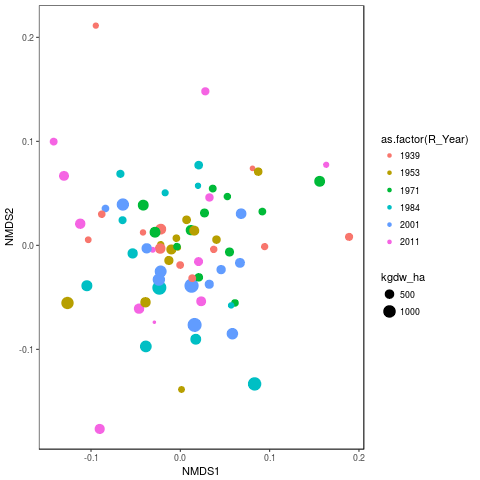

In [29]:
%%R
p.t1 = plot_ordination(physeq.plantT1, dist.bray.nmds, justDF = TRUE)


p = ggplot(p.t1,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=as.factor(R_Year), size = kgdw_ha)) +
    theme_pub()
        
p

In [30]:
%%R
ordMean = p.t1 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




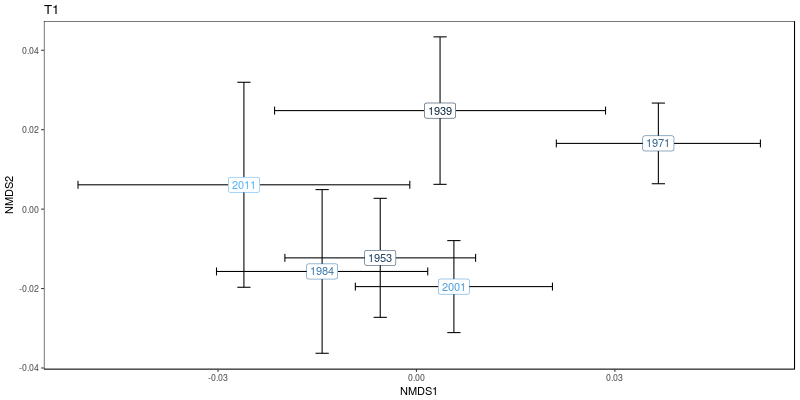

In [31]:
%%R -w 800 -h 400
pT1 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")+
   # facet_wrap(~Fert)+
    ggtitle("T1")

pT1

### Mantel of T1 

In [32]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT1)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T1.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T1.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T3


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T1.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.07992 
      Significance: 0.023 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0479 0.0643 0.0745 0.0912 
Permutation: free
Number of permutations: 999


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T1.wunif.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.06282 
      Significance: 0.065 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0543 0.0671 0.0796 0.0926 
Permutation: free
Number of permutations: 999



##  T2 ADONIS

In [33]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
physeq.plantT2

# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T2.bray.dist = distance(physeq.plantT2, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [34]:
%%R
set.seed(101)


df = as(sample_data(physeq.plantT2), "data.frame")

print("Bray-Curtis")
d = T2.bray.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis %>% print

print("w-UniFrac")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis


[1] "Bray-Curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.23615 0.078717   2.054 0.12000  0.001 ***
Genotype  11   0.46708 0.042462   1.108 0.23735  0.039 *  
Residuals 33   1.26467 0.038323         0.64265           
Total     47   1.96790                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.031581 0.0105269  3.1315 0.16598  0.001 ***
Genotype  11  0.047754 0.0043413  1.2914 0.25098  0.024 *  
Residuals 33  0.110935 0.0033617         0.58304           
Total     47  0.190270          

* Genotype has a significant effect on community composition at R1, but ADONIS is not significant for R_Year

## T2 ordination 

In [35]:
%%R
##Calculating wunifrac distances

#dist.unif = distance(ps, method = "weighted_unifrac")

## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T2.bray.dist,autotransform=F,k=3,trymax=50)




Run 0 stress 0.111785 
Run 1 stress 0.111786 
... Procrustes: rmse 0.0005269393  max resid 0.002701488 
... Similar to previous best
Run 2 stress 0.1117869 
... Procrustes: rmse 0.0005494032  max resid 0.002695254 
... Similar to previous best
Run 3 stress 0.1117856 
... Procrustes: rmse 0.0003200912  max resid 0.001288098 
... Similar to previous best
Run 4 stress 0.111785 
... New best solution
... Procrustes: rmse 0.0003985006  max resid 0.00205871 
... Similar to previous best
Run 5 stress 0.1187453 
Run 6 stress 0.1117855 
... Procrustes: rmse 0.0005935915  max resid 0.002320255 
... Similar to previous best
Run 7 stress 0.111785 
... Procrustes: rmse 0.0004214552  max resid 0.00176901 
... Similar to previous best
Run 8 stress 0.111789 
... Procrustes: rmse 0.001152439  max resid 0.005196215 
... Similar to previous best
Run 9 stress 0.1117852 
... Procrustes: rmse 0.0005795116  max resid 0.002854013 
... Similar to previous best
Run 10 stress 0.1117873 
... Procrustes: rmse 0.00

In [36]:
%%R
#Plot NMDS

p = plot_ordination(physeq.plantT2, dist.bray.nmds, justDF = TRUE)


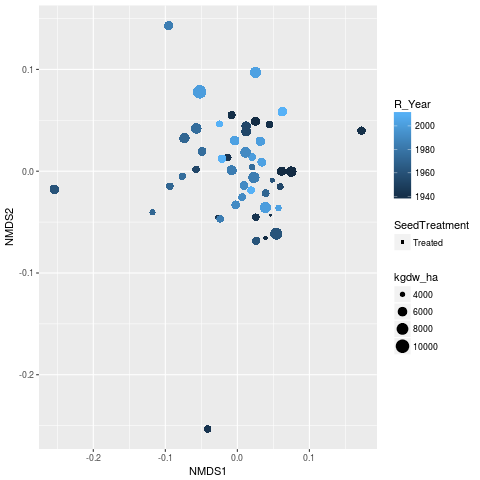

In [37]:
%%R

p1 = ggplot(p,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=R_Year, shape = SeedTreatment, size = kgdw_ha))
        
p1

In [38]:
%%R
ordMean = p %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




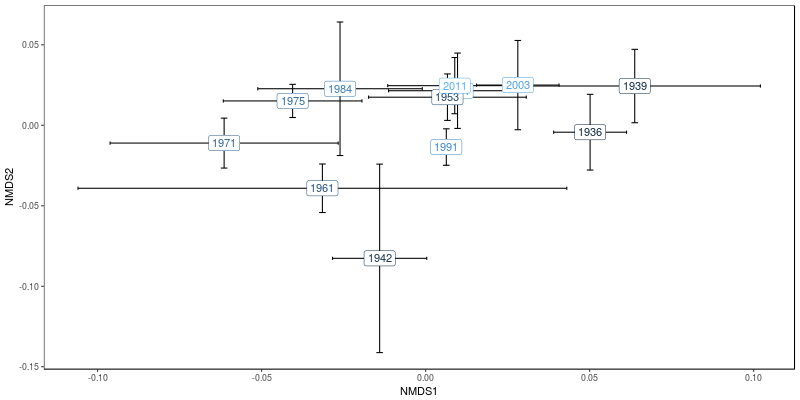

In [39]:
%%R -w 800 -h 400
ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")

In [40]:
%%R
filter(p, NMDS2 < -0.2 | NMDS1 < -0.2)

        NMDS1       NMDS2     X.sampleID TubeID ExtractionPlate PooledDNAPlate
1 -0.04125156 -0.25324060 ERA-T2_1-4c_85    380            ERA1              A
2 -0.25419760 -0.01785013 ERA-T2_4-4d_85    474            ERA4              B
  Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc
1             E6           1            45             E6 NA          1-E
2             C1           2             3             C1 NA          2-C
  primerRevLoc fwd_barcode rev_barcode  PlotID TimePoint Rep Row Pos Fert
1          1-6    TCATCGAG    CTACGCAG 1-4c_85        T2   1   4   c   85
2          2-1    AGAGTCAC    AACTCTCG 4-4d_85        T2   4   4   d   85
  PlotIndex Plant Genotype SeedTreatment R_Year ERA BG_activity.g BX_activity.g
1        44   339      339       Treated   1942   1      88.21732      19.60371
2       226  3618     3618       Treated   1961   2      76.78400      19.61642
  CB_activity.g LAP_activity.g NAG_activity.g Stage kgdw_ha FracN.leco
1      2

## T2 without outliers

In [41]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  
            Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated") #& !X.sampleID %in% 
                              #  c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T2.bray.dist = distance(physeq.plantT2, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [42]:
%%R
set.seed(101)


df = as(sample_data(physeq.plantT2), "data.frame")

print("Bray-Curtis")
d = T2.bray.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis %>% print

print("w-UniFrac")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis

[1] "Bray-Curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.23615 0.078717   2.054 0.12000  0.001 ***
Genotype  11   0.46708 0.042462   1.108 0.23735  0.039 *  
Residuals 33   1.26467 0.038323         0.64265           
Total     47   1.96790                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.031581 0.0105269  3.1315 0.16598  0.001 ***
Genotype  11  0.047754 0.0043413  1.2914 0.25098  0.024 *  
Residuals 33  0.110935 0.0033617         0.58304           
Total     47  0.190270          

### Ordinate T2 with nmds

In [43]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T2.bray.dist,autotransform=F,k=3,trymax=50)



Run 0 stress 0.111785 
Run 1 stress 0.111786 
... Procrustes: rmse 0.0005269393  max resid 0.002701488 
... Similar to previous best
Run 2 stress 0.1117869 
... Procrustes: rmse 0.0005494032  max resid 0.002695254 
... Similar to previous best
Run 3 stress 0.1117856 
... Procrustes: rmse 0.0003200912  max resid 0.001288098 
... Similar to previous best
Run 4 stress 0.111785 
... New best solution
... Procrustes: rmse 0.0003985006  max resid 0.00205871 
... Similar to previous best
Run 5 stress 0.1187453 
Run 6 stress 0.1117855 
... Procrustes: rmse 0.0005935915  max resid 0.002320255 
... Similar to previous best
Run 7 stress 0.111785 
... Procrustes: rmse 0.0004214552  max resid 0.00176901 
... Similar to previous best
Run 8 stress 0.111789 
... Procrustes: rmse 0.001152439  max resid 0.005196215 
... Similar to previous best
Run 9 stress 0.1117852 
... Procrustes: rmse 0.0005795116  max resid 0.002854013 
... Similar to previous best
Run 10 stress 0.1117873 
... Procrustes: rmse 0.00

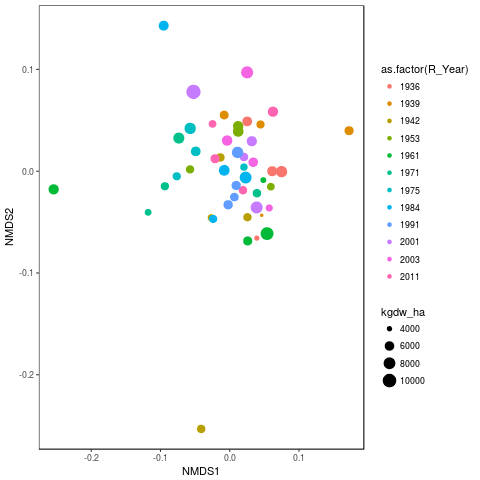

In [44]:
%%R
p.t2 = plot_ordination(physeq.plantT2, dist.bray.nmds, justDF = TRUE)


p = ggplot(p.t2,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=as.factor(R_Year), size = kgdw_ha)) +
    theme_pub()
        
p

In [45]:
%%R
ordMean = p.t2 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




In [ ]:
%%R -w 800 -h 400
pT2 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")+
    ggtitle("R1")
pT2

* Is there a curvilinear relationship?

* Careful whether or not using outliers 

## Curvilinear relationship between year of release and MCC?

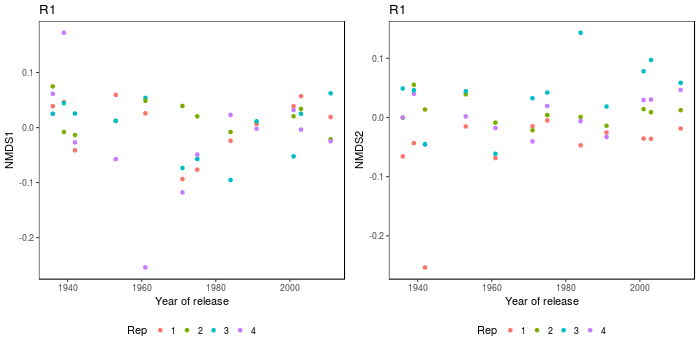

In [47]:
%%R -w 700 -h 350
p1 = ggplot(p.t2, aes(x = R_Year, y = NMDS1)) +
    geom_point(aes(color =Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("NMDS1")+
    ggtitle("R1")

p2 = ggplot(p.t2, aes(x = R_Year, y = NMDS2)) +
    geom_point(aes(color = Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("NMDS2")+
    ggtitle("R1")
grid.arrange(p1, p2, ncol =2)

* hmm, movement along axis 1 is interesting, try in PCoA

In [ ]:
%%R
pcoa = ordinate(physeq.plantT2, 
                method = "PCoA", 
                distance = T2.bray.dist)

p = plot_ordination(physeq, pcoa, justDF = TRUE)


In [ ]:
%%R -w 700 -h 350
p1 = ggplot(p, aes(x = R_Year, y = Axis.1)) +
    geom_point(aes(color =Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("Axis.1")+
    ggtitle("R1")

p2 = ggplot(p, aes(x = R_Year, y = Axis.2)) +
    geom_point(aes(color = Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("Axis.2")+
    ggtitle("R1")
grid.arrange(p1, p2, ncol =2)

### plot of merged samples

In [ ]:
%%R
tmp = p %>% group_by(R_Year) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1))) 
    ggplot(tmp, aes(x = R_Year, y = mAxis.1)) +
    geom_point() +
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

In [ ]:
%%R
m = lm(mAxis.1~poly(R_Year,2), data = tmp)
anova(m)
summary(m)

* but axis 1 only accounts for 10% of the variation in MCC

In [ ]:
%%R
# on raw data
m = lmer(Axis.1~poly(R_Year,2) + (1|Rep), data = p)
anova(m)
summary(m)

In [ ]:
%%R
r.squaredGLMM(m)

### Mantel test at T2

In [ ]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT2)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T2.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T2.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T2

## T3

In [ ]:
%%R
# subset phyloseq object
physeq.plantT3 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T3")
physeq.plantT3

# create unifrac distance matrix
registerDoParallel(cores=28)
T3.wunif.dist = distance(physeq.plantT3, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T3.bray.dist = distance(physeq.plantT3, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [ ]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT3), "data.frame")
d = T3.bray.dist
print("Bray-curtis")
T3adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T3adonis %>% print

print("")
print("weighted UniFrac")
d = T3.wunif.dist
T3adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T3adonis

* Genotype is significant at T3 when interaction term is not included.  However it describes a lower portion of variance than the untransformed data

### Ordinate T3 with nmds

In [ ]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T3.bray.dist,autotransform=F,k=3,trymax=50)



In [ ]:
%%R
p.t3 = plot_ordination(physeq.plantT3, dist.bray.nmds, justDF = TRUE)


p2 = ggplot(p.t3,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=Genotype, size = kgdw_ha)) +
    theme_pub()
        
p2

In [ ]:
%%R
ordMean = p.t3 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




In [ ]:
%%R -w 800 -h 400
pT3 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2") +
    ggtitle("R3")
pT3

In [ ]:
%%R -w 800 -h 600
grid.arrange(pT3, p2, ncol = 1)

### Mantel test at T3

In [ ]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT3)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T3.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T3.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T3

# Plot  figures with grid.arrange

# CAP

In [ ]:
%%R
# subset phyloseq object to just rhizosphere plants, time point 2 and only treated seeds
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
phy

In [ ]:
%%R
T2.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [ ]:
%%R
sample_data(phy) %>% colnames

In [ ]:
%%R
sample_data(phy)$Rep = as.factor(sample_data(phy)$Rep)
# cap.ord = ordinate(
#     physeq = phy, 
#     method = "CAP",
#     distance = T2.wunif.dist,
#     formula = ~ R_Year + Rep + Condition())

ordcap = ordinate(phy, "CAP", "bray", ~poly(R_Year,2) + Condition(Rep))
plot_ordination(phy, ordcap, "samples", color="R_Year")




# # CAP plot
# cap.plot <- plot_ordination(phy, cap.ord, axes = c(1,2)) + 
#     geom_point(aes(fill = Genotype), pch= 21,alpha= 1) 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    
    #scale_color_manual(values = c("#1CE6FF","#B79762", "#004D43", "#8FB0FF", "#997D87", "#5A0007"), name = "Genotype",
 #                      labels = c("B73xB97", "B73xTx303", "ECHES","FAGES","HELAN",     "SORSUD")) 




# Now add the environmental variables as arrows
# arrowmat <- vegan::scores(cap.ord, display = "bp")

# rownames(arrowmat) = c("R_Year", "Rep")
# #rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# # Add labels, make a data.frame
# arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
# arrow_map <- aes(xend = CAP1, 
#     yend = CAP2, 
#     x = 0, 
#     y = 0, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# label_map <- aes(x = 1.3 * CAP1, 
#     y = 1.3 * CAP2, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# arrowhead = arrow(length = unit(0.02, "npc"))

# # Make a new graphic
# p = cap.plot + 
# geom_segment(arrow_map, 
#     size = .5, 
#     data = arrowdf, 
#     color = "gray", 
#     arrow = arrowhead
#     ) + 
# geom_text(label_map,   
#     data = arrowdf, 
#     show_guide = FALSE) 
# p = p + theme_pub() 
# #p = p + theme(panel.border = element_blank(), legend.position = "right", legend.text = element_text(size = 10)) 
# p = p + theme(legend.position = "left", legend.text = element_text()) 

#save legend for independent formatting
# g_legend<-function(a.gplot){
#     tmp <- ggplot_gtable(ggplot_build(a.gplot))
#     leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
#     legend <- tmp$grobs[[leg]]
#     legend
# }
# 

                        
#legend1 <- g_legend(p)

                     
# p =  p + theme(axis.line.x = element_line(color="black", size = 1),
#     axis.line.y = element_line(color="black", size = 1), legend.position = "left")
# p = p + theme(legend.position = "bottom")
# p

In [ ]:
%%R
anova(ordcap)

## Finally try DESeq2

In [49]:
%%R 
# loading

phy.thresh = readRDS('ERA_thresh.rds')

#Subset to T2
phy.thresh = subset_samples(phy.thresh, TimePoint == "T2" & SeedTreatment == "Treated", TRUE)
phy.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [50]:
%%R
sample_data(phy.thresh)$Rep = as.factor(sample_data(phy.thresh)$Rep)
sample_data(phy.thresh)$Row = as.factor(sample_data(phy.thresh)$Row)
sample_data(phy.thresh)$Fert = as.factor(sample_data(phy.thresh)$Fert)
sample_data(phy.thresh)$ERA = as.factor(sample_data(phy.thresh)$ERA)
sample_data(phy.thresh)$R_Year.c = sample_data(phy.thresh)$R_Year - 1935

In [70]:
%%R
dds = phyloseq_to_deseq2(phy.thresh, ~Rep + poly(R_Year.c,2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"          "Rep1"               "Rep2"              
[4] "Rep3"               "Rep4"               "poly.R_Year.c..2.1"
[7] "poly.R_Year.c..2.2"


In [71]:
%%R
Year.x.res = results(d_dds, name="poly.R_Year.c..2.1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x.res) 




out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [72]:
%%R
Year.x2.res = results(d_dds, name="poly.R_Year.c..2.2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x2.res) 




out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 2, 0.044% 
LFC < 0 (down)   : 11, 0.24% 
outliers [1]     : 0, 0% 
low counts [2]   : 2758, 60% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [84]:
%%R
toKeep = Year.x2.res %>% as.data.frame %>% mutate(OTU = rownames(Year.x2.res)) %>% filter(padj < 0.05) %>% .$OTU

In [87]:
%%R
ToPlot = physeq.plantT2 %>%
        prune_taxa(toKeep, .) %>%
        psmelt()
        

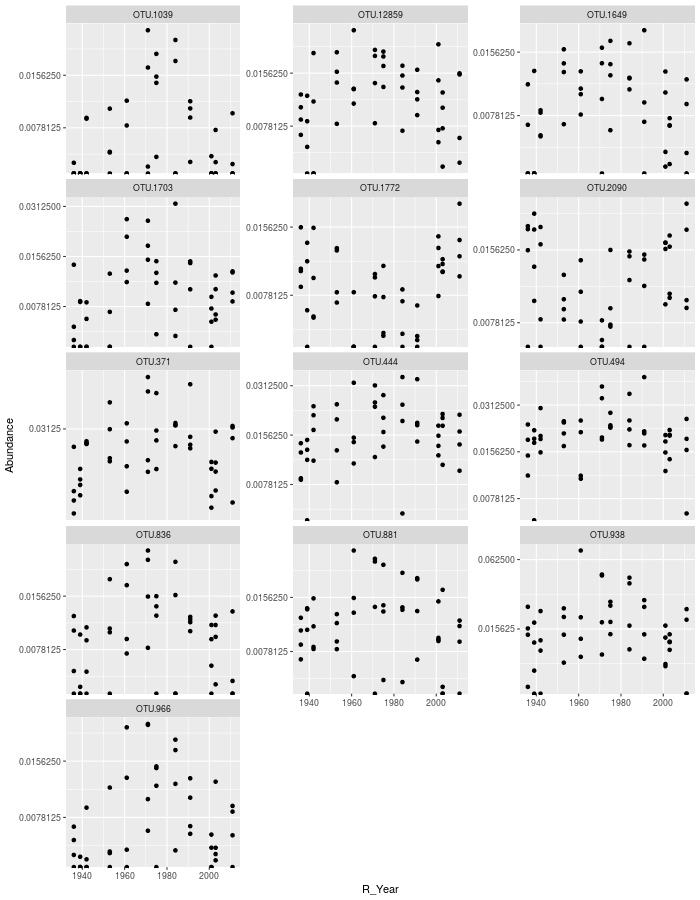

In [90]:
%%R -w 700 -h 900
require(scales)
p = ggplot(ToPlot, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 3)+
        scale_y_continuous(trans=log2_trans())
p

In [103]:
%%R
colnames(ToPlot)

 [1] "OTU"             "Sample"          "Abundance"       "X.sampleID"     
 [5] "TubeID"          "ExtractionPlate" "PooledDNAPlate"  "Sample.Well.ID" 
 [9] "PrimerPlate"     "Primer.Number"   "Primer.Well.ID"  "X"              
[13] "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"     "rev_barcode"    
[17] "PlotID"          "TimePoint"       "Rep"             "Row"            
[21] "Pos"             "Fert"            "PlotIndex"       "Plant"          
[25] "Genotype"        "SeedTreatment"   "R_Year"          "ERA"            
[29] "BG_activity.g"   "BX_activity.g"   "CB_activity.g"   "LAP_activity.g" 
[33] "NAG_activity.g"  "Stage"           "kgdw_ha"         "FracN.leco"     
[37] "FracC.leco"      "kgN_ha"          "RGR"             "AGR"            
[41] "Nprod"           "NupR"            "d15N"            "X15N_AtPercent" 
[45] "FracN"           "FracN_fromSoil"  "FracN_fromFert"  "kgFertN_ha"     
[49] "kgSoilN_ha"      "Planted"         "Rank1"           "Rank2"          

In [129]:
%%R
ToPlot %>%
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>%
    unique %>% print

PolyTaxa = ToPlot %>% .$OTU %>% unique

          OTU             Rank2                 Rank3                  Rank4
574   OTU.938  __Proteobacteria __Deltaproteobacteria         __Myxococcales
430   OTU.494  __Actinobacteria   __Micromonosporales   __Micromonosporaceae
320   OTU.371 __Verrucomicrobia    __OPB35_soil_group __uncultured_bacterium
371   OTU.444     __Chloroflexi      __Thermomicrobia         __JG30-KF-CM45
148  OTU.1703  __Proteobacteria __Deltaproteobacteria         __Myxococcales
511   OTU.881     __Chloroflexi      __Chloroflexales      __Chloroflexaceae
20   OTU.1039     __Chloroflexi        __Anaerolineae       __Anaerolineales
466   OTU.836     __Chloroflexi        __Anaerolineae       __Anaerolineales
96  OTU.12859   __Acidobacteria               __DA023 __uncultured_bacterium
616   OTU.966     __Chloroflexi        __Anaerolineae       __Anaerolineales
257  OTU.2090 __Verrucomicrobia      __Spartobacteria   __Chthoniobacterales
101  OTU.1649   __Bacteroidetes    __Sphingobacteriia   __Sphingobacteriales

In [122]:
%%R
mat = ToPlot %>%
    group_by(OTU, Rank2, Rank5, Rank6, Plant, R_Year) %>%
    summarize(mAbund = mean(Abundance)) %>%
    as.data.frame() %>%
       mutate(Taxa = paste(OTU, ":_", Rank5, "_", Rank6, sep = "")) %>%
    select(Taxa, R_Year, mAbund) %>%
    spread(R_Year,mAbund) 

rownames(mat) = mat$Taxa
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                                                                 1936
OTU.1039:___Anaerolineaceae___uncultured                  0.001231781
OTU.12859:_NA_NA                                          0.009322367
OTU.1649:___Chitinophagaceae___Flavisolibacter            0.004514325
OTU.1703:___Sorangiineae___uncultured                     0.006189560
OTU.1772:___Planctomycetaceae___uncultured                0.011079897
OTU.2090:___DA101_soil_group___uncultured_bacterium       0.013552187
OTU.371:_NA_NA                                            0.020544173
OTU.444:___uncultured_bacterium_NA                        0.010760814
OTU.494:___Micromonospora_NA                              0.016972468
OTU.836:___Anaerolineaceae___uncultured                   0.006992521
OTU.881:___Roseiflexus___uncultured_Chloroflexi_bacterium 0.009467945
OTU.938:___Sorangiineae___uncultured                      0.014752191
OTU.966:___Anaerolineaceae___uncultured                   0.004447558
                    

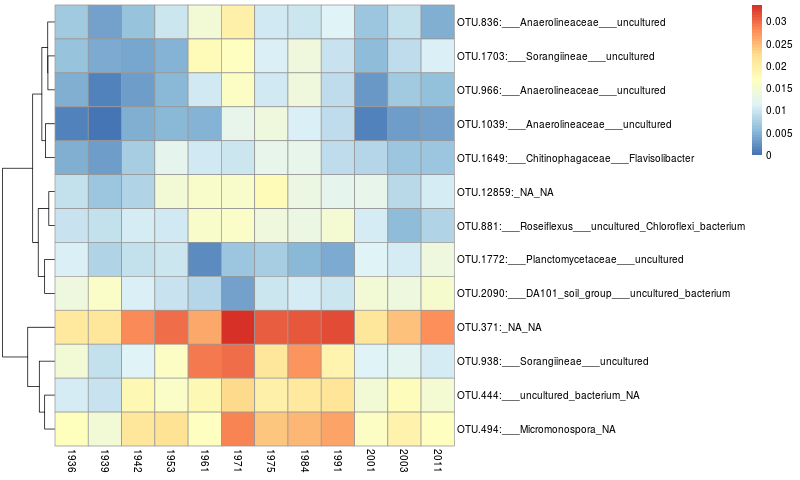

In [124]:
%%R -w 800
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

## are these taxa rhizosphere responders or background?

In [132]:
%%R
l2f.rhiz = read.csv(file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv", header = TRUE)

In [161]:
%%R
mat = l2f.rhiz %>% filter(OTU %in% PolyTaxa & TimePoint == "T2") %>%
 select(OTU, Plant, log2FoldChange) %>%
    spread(Plant, log2FoldChange) %>%
    .[,c("OTU", "322","330"  ,   "339" ,    "354"   ,  "3618"  ,  "3517"  ,  "3541" ,   "3475" ,  
 "3394",    "34M95" ,  "34N42" ,  "P1151HR")]



In [162]:
%%R
rownames(mat) = mat$OTU
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                 322        330         339         354       3618       3517
OTU.1039   0.2908125         NA  2.18205771  1.61656212  2.0510700  3.2540991
OTU.12859 -0.2397460 -0.5754415  0.38721026  1.11154761  1.5169609  1.4313313
OTU.1649  -0.5159308 -0.3407492 -0.21854781  1.06830720  0.7357834  0.9866756
OTU.1703   0.1534538 -0.3352692 -0.67550266 -0.07204963  2.5593706  2.3710454
OTU.1772  -0.5228727 -1.1074167 -0.71203634 -0.75595338 -2.7317692 -1.4725948
OTU.2090   0.6692167  0.7237254  0.37662535 -0.50265549 -0.4286481 -1.9297279
OTU.371   -0.1695206 -0.0257923  0.96797779  1.00239875  0.7180361  1.5250980
OTU.444   -0.4953284 -0.3602583  1.10514355  0.77263783  1.2268522  1.7480014
OTU.494    0.2290707  0.3247341  1.10276956  0.96659137  0.5220282  1.9066422
OTU.836    0.1369107 -0.6309979  0.01551551  1.00756768  1.9947083  2.6895855
OTU.881    1.0760508  1.4617163  1.87836357  1.31169583  2.9257842  3.0186452
OTU.938    0.4555728 -0.3795342  0.24484203  0.78325659  2.92366

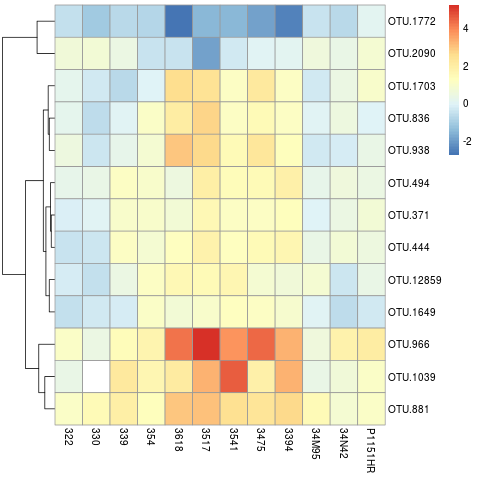

In [163]:
%%R
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

In [57]:
%%R
Fert.sig = l2f.Fert %>% filter(padj < .05)
    Fert.sig %>% head %>% print
Rhiz.sig = l2f.rhiz %>% filter(p.adj < .05)

    baseMean log2FoldChange      lfcSE     stat       pvalue        padj
1  57.336477      0.3088018 0.09036034 3.417448 6.321110e-04 0.049772638
2  31.608509      1.3851356 0.33690111 4.111401 3.932652e-05 0.005594198
3  33.698029      1.1325439 0.32376969 3.497992 4.687744e-04 0.041035789
4 175.345301      0.7820358 0.19220954 4.068663 4.728373e-05 0.006330458
5  95.511586      0.8416117 0.21868204 3.848563 1.188125e-04 0.013520866
6   6.678833      1.4443268 0.34166679 4.227296 2.365160e-05 0.004364670
        OTU Contrast    Rank1            Rank2                 Rank3
1  OTU.2489     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
2 OTU.14139     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
3 OTU.15685     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
4    OTU.69     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
5    OTU.78     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
6  OTU.3468     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
      

In [63]:
%%R
betas <- coef(d_dds)
colnames(betas)

[1] "Intercept"          "Rep1"               "Rep2"              
[4] "Rep3"               "Rep4"               "poly.R_Year.c..2.1"
[7] "poly.R_Year.c..2.2"


In [102]:
%%R
str(betas)

 num [1:4592, 1:7] 2.728 -0.989 3.925 1.453 -0.197 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:4592] "OTU.871" "OTU.9547" "OTU.523" "OTU.1107" ...
  ..$ : chr [1:7] "Intercept" "Rep1" "Rep2" "Rep3" ...


In [98]:
%%R
betas[topGenes,]

          Intercept        Rep1        Rep2         Rep3          Rep4
OTU.1039   1.041147  0.05714519  0.02532954  0.257559939 -0.3400340833
OTU.966    1.330184  0.29385895 -0.26922230  0.011685566 -0.0363214611
OTU.836    1.874405  0.32653771  0.33899453 -0.341953467 -0.3235777175
OTU.938    3.701478 -0.25990367 -0.06701055 -0.031728763  0.3586450750
OTU.1649   1.538524  0.07841166 -0.59854121  0.519433438  0.0006969883
OTU.1772   1.356840 -0.14485261  0.27019866  0.011954963 -0.1373002463
OTU.1703   1.971579  0.06299148  0.26585231 -0.336931575  0.0080889035
OTU.12859  2.393299 -0.16554469  0.15336188 -0.185677355  0.1978615130
OTU.2090   2.195215 -0.89135610  0.17231439  0.205546381  0.5134965788
OTU.881    2.346700  0.53335660 -0.31229839 -0.264681857  0.0436249821
OTU.494    3.835234  0.54253796 -0.10938098 -0.006567204 -0.4265876139
OTU.371    4.612532  0.13079330 -0.16518455 -0.108040761  0.1424346239
OTU.444    3.332480  0.14005337 -0.24351899  0.033769527  0.0696979819
OTU.83

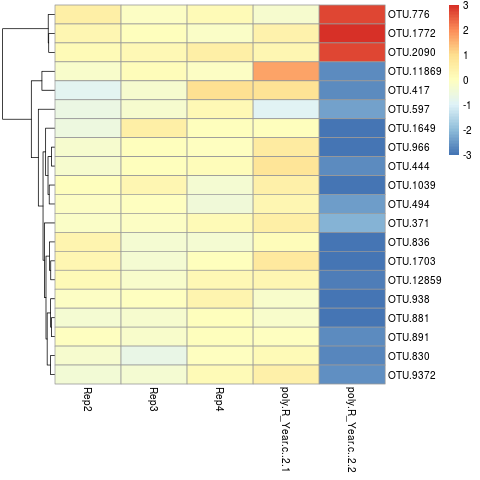

In [66]:
%%R
topGenes <- head(order(Year.x2.res$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
pheatmap::pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)

In [ ]:
DF = results(d_dds)

supp = tax_table(phy.thresh)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "R_Year"
        YR = DF

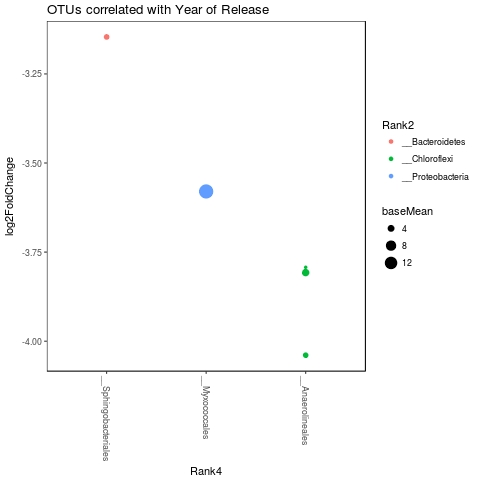

In [147]:
%%R
sigtab = YR %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Year of Release")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

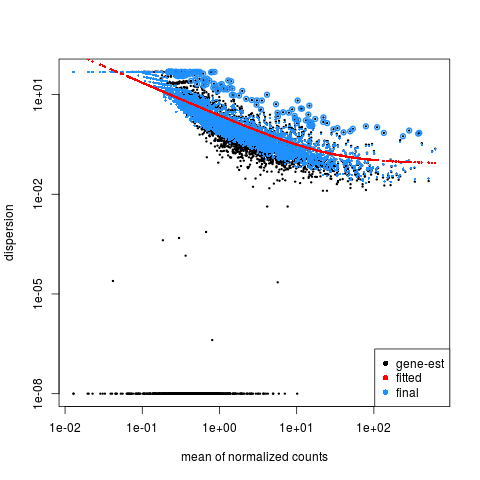

In [152]:
%%R
plotDispEsts(d_dds)

In [177]:
%%R
DF = results(d_dds, contrast = c("ERA", "1", "3"))

supp = tax_table(phy.thresh)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "R_Year_poly1"
        RYear_poly1 = DF

In [ ]:
%%R
sigtab = RYear_poly1 %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Year of Release")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [170]:
%%R
head(sigtab)

   baseMean log2FoldChange     lfcSE     stat       pvalue         padj
1 15.988529       1.148456 0.2812720 4.083080 4.444272e-05 0.0269471017
2  4.498885       1.388474 0.2797634 4.963029 6.940227e-07 0.0006312136
3  5.727666       1.093523 0.2758620 3.964023 7.369722e-05 0.0335138089
4  3.188988       1.467852 0.2810343 5.223036 1.760134e-07 0.0003201684
     Rank1            Rank2                 Rank3               Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria      __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria      __Myxococcales
3 Bacteria __Proteobacteria __Gammaproteobacteria __Oceanospirillales
4 Bacteria    __Chloroflexi        __Anaerolineae    __Anaerolineales
                 Rank5             Rank6                              Rank7
1       __Sorangiineae      __uncultured                               <NA>
2       __Sorangiineae      __uncultured                               <NA>
3 __Oceanospirillaceae __Pseudospirillum __uncultured_gamma_pr

In [150]:
%%R
library("vsn")
notAllZero <- (rowSums(counts(dds))>0)
meanSdPlot(log2(counts(dds,normalized=TRUE)[notAllZero,] + 1))


Error in .local(object, ...) : 
  first calculate size factors, add normalizationFactors, or set normalized=FALSE


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in .local(object, ...) : 
  first calculate size factors, add normalizationFactors, or set normalized=FALSE

  warnings.warn(x, RRuntimeWarning)


# Pseudomonas

In [ ]:
%%R
physeq.core %>% 
    tax_table() %>% 
    head()

In [ ]:
%%R
pdms = subset_taxa(physeq.snorm, Rank6=="__Pseudomonas") %>%
    subset_samples(Ntreat == "Nneg")
pdms

In [ ]:
%%R
title = "plot_bar; Pseudomonas-only"
plot_bar(pdms, "Genotype", "Abundance", title=title)

In [ ]:
%%R
pdms.mean = psmelt(pdms) %>%
        group_by(OTU,TimePoint, Genotype) %>%
         summarize(relAbundance = mean(Abundance))

In [ ]:
%%R -w 700 -h 700
ggplot(pdms.mean, aes(x = Genotype, y = relAbundance)) +
    geom_bar(stat = "identity") + 
    facet_grid(OTU~TimePoint, scales = "free_x")+
    theme(axis.text.x = element_text(angle = 60))
   # geom_text(aes(y = relAbundance + .001, label=sig))

In [ ]:
%%R
tax_table(pdms)